In [1]:
import os
import albumentations as A
import pandas as pd
import numpy as np
import cv2
import shutil
import uuid

In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
!mkdir ~/.kaggle

In [5]:
!cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle competitions download severstal-steel-defect-detection

100% 1.56G/1.57G [00:16<00:00, 68.1MB/s]
100% 1.57G/1.57G [00:16<00:00, 100MB/s] 


In [ ]:
! unzip /content/severstal-steel-defect-detection.zip

In [9]:
 !mkdir ./gdrive/MyDrive/Steel_dataset

In [10]:
shutil.copytree("./test_images",'./gdrive/MyDrive/Steel_dataset/test_images')
shutil.copytree("./train_images",'./gdrive/MyDrive/Steel_dataset/train_images')

'./gdrive/MyDrive/Steel_dataset/train_images'

In [11]:
train_df=pd.read_csv("./train.csv")

In [12]:
df_class_2=train_df[train_df['ClassId']==2].reset_index(drop=True)
df_class_1=train_df[train_df['ClassId']==1].reset_index().drop('index',axis=1)
df_class_4=train_df[train_df['ClassId']==4].reset_index().drop('index',axis=1)

In [13]:
prob_for_class2=1.
prob_for_class1=0.4
prob_for_class4=0.5

In [14]:
def augmentation(dataframe:pd.DataFrame,prob_for_class:float)->pd.DataFrame:
  n_records=int(round(prob_for_class*(len(dataframe)-1)))
  new_df=dict({
      'ImageId':[],
      'ClassId':[],
      'EncodedPixels':[],
      'ImageId_ClassId':[]
  })
  for i in range(n_records):
    record=dataframe.loc[np.random.randint(n_records)]
    image_name=record["ImageId"]
    image_class=record['ClassId']
    image=cv2.imread(os.path.join("./train_images",image_name))
    image=cv2.resize(image,(1600,256))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask=rle_to_mask(record['EncodedPixels'])
    transformed=transform(image=image,mask=mask)
    transformed_image=transformed['image']
    transformed_mask=transformed['mask']
    encoded_transformed_mask=mask_to_rle(transformed_mask.T)
    u_id=str(uuid.uuid1())
    save_directory_path=os.path.join("/content/gdrive/MyDrive/Steel_dataset/train_images",(u_id+'.jpg'))
    new_df['ImageId'].append(u_id+'.jpg')
    new_df['ClassId'].append(image_class)
    new_df['EncodedPixels'].append(encoded_transformed_mask)
    new_df['ImageId_ClassId'].append(u_id+'.jpg'+'_'+str(image_class))
    cv2.imwrite(save_directory_path,transformed_image)
  return pd.DataFrame(new_df)

In [14]:
# def augmentation_test(dataframe:pd.DataFrame):
#   record=dataframe.loc[np.random.randint(10)]
#   image=cv2.imread(os.path.join("./train_images",record['ImageId']),0)
#   image=cv2.resize(image,(1600,256))
#   mask=rle_to_mask(record['EncodedPixels'])
#   transformed=transform(image=image,mask=mask)
#   transformed_image=transformed['image']
#   transformed_mask=transformed['mask']
#   return transformed_image,transformed_mask,mask

In [15]:
train_df['ImageId_ClassId'] = train_df.apply(lambda x: '{}_{}'.format(x.ImageId, x.ClassId), axis=1)

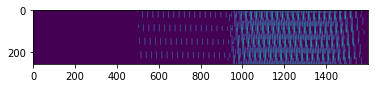

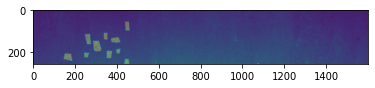

In [ ]:
plt.imshow(img)
plt.imshow(mask,alpha=0.3)

In [20]:
import matplotlib.pyplot as plt

In [18]:
import albumentations as A
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
])

In [16]:
def mask_to_rle(mask):
    """
    params:  mask - numpy array
    returns: run-length encoding string (pairs of start & length of encoding)
    """
    # turn a n-dimensional array into a 1-dimensional series of pixels
    # for example:
    #     [[1. 1. 0.]
    #      [0. 0. 0.]   --> [1. 1. 0. 0. 0. 0. 1. 0. 0.]
    #      [1. 0. 0.]]
    flat = mask.flatten()
    
    # we find consecutive sequences by overlaying the mask
    # on a version of itself that is displaced by 1 pixel
    # for that, we add some padding before slicing
    padded = np.concatenate([[0], flat, [0]])
    
    # this returns the indices where the sliced arrays differ
    runs = np.where(padded[1:] != padded[:-1])[0] 
    # indexes start at 0, pixel numbers start at 1
    runs += 1

    # every uneven element represents the start of a new sequence
    # every even element is where the run comes to a stop
    # subtract the former from the latter to get the length of the run
    runs[1::2] -= runs[0::2]
 
    # convert the array to a string
    return ' '.join(str(x) for x in runs)

In [17]:
def rle_to_mask(lre, shape=(1600, 256)):
    '''
    params:  rle   - run-length encoding string (pairs of start & length of encoding)
             shape - (width,height) of numpy array to return 
    
    returns: numpy array with dimensions of shape parameter
    '''    
    # the incoming string is space-delimited
    runs = np.asarray([int(run) for run in lre.split(' ')])
    
    # we do the same operation with the even and uneven elements, but this time with addition
    runs[1::2] += runs[0::2]
    # pixel numbers start at 1, indexes start at 0
    runs -= 1
    
    # extract the starting and ending indeces at even and uneven intervals, respectively
    run_starts, run_ends = runs[0::2], runs[1::2]
    
    # build the mask
    h, w = shape
    mask = np.zeros(h*w, dtype=np.uint8)
    for start, end in zip(run_starts, run_ends):
        mask[start:end] = 1
    
    # transform the numpy array from flat to the original image shape
    return mask.reshape(shape).T

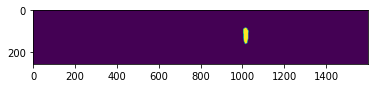

In [50]:
img,mask,org=augmentation_test(train_df)
lre=mask_to_rle(mask.T)
plt.imshow(mask)
lree=rle_to_mask(lre)


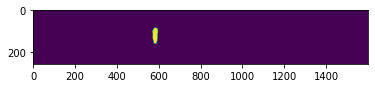

In [51]:
plt.imshow(org)

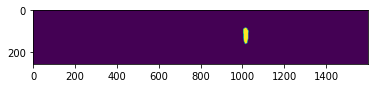

In [52]:
plt.imshow(lree)

In [43]:
pd.Series(mask.flatten()).value_counts()

0    405204
1      4396
dtype: int64

In [28]:
mask.flatten().shape

(409600,)

In [26]:
flat=mask.flatten()

In [27]:
padded = np.concatenate([[0], flat, [0]])

In [29]:
padded.shape

(409602,)

In [37]:
runs = np.where(padded[1:] != padded[:-1])[0] 
runs += 1

In [38]:
runs

array([   569,    585,   2169,   2185,   3769,   3785,   5369,   5385,
         6969,   6985,   8569,   8585,  10169,  10185,  11770,  11785,
        13370,  13385,  14970,  14985,  16570,  16585,  18170,  18185,
        19770,  19785,  21370,  21385,  22970,  22985,  24570,  24585,
        26170,  26185,  27770,  27785,  29370,  29385,  30970,  30985,
        32571,  32585,  34171,  34185,  35771,  35785,  37371,  37385,
        38971,  38985,  40571,  40585,  42171,  42185,  43771,  43785,
        45371,  45385,  46971,  46985,  48571,  48585,  50171,  50185,
        51771,  51785,  53372,  53385,  54972,  54985,  56572,  56585,
        58172,  58185,  59772,  59785,  61372,  61385,  62972,  62985,
        64572,  64585,  66172,  66185,  67772,  67785,  69372,  69385,
        70972,  70985,  72572,  72585,  74172,  74185,  75773,  75786,
        77373,  77386,  78973,  78986,  80573,  80586,  82173,  82186,
        83773,  83786,  85373,  85386,  86973,  86986,  88573,  88586,
      

In [39]:
runs[1::2]-=runs[::2]

In [40]:
runs

array([   569,     16,   2169,     16,   3769,     16,   5369,     16,
         6969,     16,   8569,     16,  10169,     16,  11770,     15,
        13370,     15,  14970,     15,  16570,     15,  18170,     15,
        19770,     15,  21370,     15,  22970,     15,  24570,     15,
        26170,     15,  27770,     15,  29370,     15,  30970,     15,
        32571,     14,  34171,     14,  35771,     14,  37371,     14,
        38971,     14,  40571,     14,  42171,     14,  43771,     14,
        45371,     14,  46971,     14,  48571,     14,  50171,     14,
        51771,     14,  53372,     13,  54972,     13,  56572,     13,
        58172,     13,  59772,     13,  61372,     13,  62972,     13,
        64572,     13,  66172,     13,  67772,     13,  69372,     13,
        70972,     13,  72572,     13,  74172,     13,  75773,     13,
        77373,     13,  78973,     13,  80573,     13,  82173,     13,
        83773,     13,  85373,     13,  86973,     13,  88573,     13,
      

In [ ]:
rle_manual=" ".join(for x in runs)

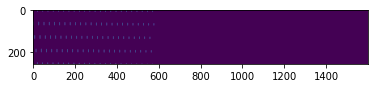

In [23]:
plt.imshow(lree)

In [27]:
os.listdir('./gdrive/MyDrive/Steel_dataset')

['test_images', 'train_images', 'aug_train.csv']

In [19]:
df_2=augmentation(df_class_2,prob_for_class2)

In [20]:
df_4=augmentation(df_class_4,prob_for_class4)

In [21]:
df_1=augmentation(df_class_1,prob_for_class1)

In [22]:
train_df=pd.concat([train_df,df_2,df_4,df_1],axis=0).reset_index(drop=True)

In [23]:
train_df.to_csv("./gdrive/MyDrive/Steel_dataset/aug_train.csv")

In [24]:
pd.read_csv('./gdrive/MyDrive/Steel_dataset/aug_train.csv')

,Unnamed: 0,ImageId,ClassId,EncodedPixels,ImageId_ClassId
0,0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg_1
1,1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...,0007a71bf.jpg_3
2,2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,000a4bcdd.jpg_1
3,3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...,000f6bf48.jpg_4
4,4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...,0014fce06.jpg_3
...,...,...,...,...,...
8094,8094,87097994-c4da-11ed-8a06-0242ac1c000c.jpg,1,45415 11 45667 25 45923 29 46179 33 46433 38 4...,87097994-c4da-11ed-8a06-0242ac1c000c.jpg_1
8095,8095,870efc70-c4da-11ed-8a06-0242ac1c000c.jpg,1,17806 23 18055 54 18304 69 18552 86 18801 99 1...,870efc70-c4da-11ed-8a06-0242ac1c000c.jpg_1
8096,8096,87159fda-c4da-11ed-8a06-0242ac1c000c.jpg,1,105524 28 105780 34 106035 41 106291 47 106547...,87159fda-c4da-11ed-8a06-0242ac1c000c.jpg_1
8097,8097,871b5da8-c4da-11ed-8a06-0242ac1c000c.jpg,1,354182 9 354435 20 354689 28 354943 35 354985 ...,871b5da8-c4da-11ed-8a06-0242ac1c000c.jpg_1


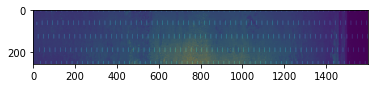

In [ ]:
x=train_df[train_df['ImageId']==os.listdir('/content/dump')[np.random.randint(100)]]
image=cv2.imread(os.path.join("./dump",x['ImageId'].values[0]),0)
plt.imshow(image)
mask=rle_to_mask(x['EncodedPixels'].values[0])
plt.imshow(mask,alpha=.5)

In [ ]:
train_df[train_df['ImageId']==os.listdir('/content/dump')[np.random.randint(1000)]]


,ImageId,ClassId,EncodedPixels,ImageId_ClassId
7772,d82fb480-c41e-11ed-87f0-0242ac1c000c.jpg,1,678 20 2278 20 3878 20 5478 20 7078 20 8678 20...,d82fb480-c41e-11ed-87f0-0242ac1c000c.jpg_1


In [ ]:
x['EncodedPixels'].values[0]

'92674 64 92930 127 93186 127 93442 127 93698 127 93954 127 94210 127 94466 127 94722 127 94978 127 95234 127 95490 128 95746 128 96002 128 96258 128 96514 128 96770 128 97042 112 97330 80 97618 48 97906 16 313083 6 313328 17 313574 27 313819 38 314064 49 314309 60 314554 71 314800 81 315045 92 315295 98 315551 98 315807 98 316063 98 316318 99 316574 99 316830 99 317086 99 317342 99 317598 99 317854 99 318109 100 318365 100 318621 100 318877 100 319137 96 319399 90 319661 84 319923 78 320185 72 320448 65 320710 59 320972 53 321234 47 321496 41 321758 35 322021 28 322283 22 322545 16 322807 10 323069 4'

In [62]:
aug_train=pd.read_csv("aug_train.csv")

,Unnamed: 0,ImageId,ClassId,EncodedPixels,ImageId_ClassId
